In [ ]:
!pip install yfinance

In [ ]:
# Import all the packages for analysis
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
stock_data = yf.download('AAPL', start='2016-11-01', end='2021-10-01')   #importing dataset from the web
print(stock_data.head())          #printing the head of dataset
stock_data.to_csv('Dataset.csv')  #downloading csv format of the dataset

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-11-01  28.365000  28.442499  27.632500  27.872499  25.951244  175303200
2016-11-02  27.850000  28.087500  27.807501  27.897499  25.974527  113326800
2016-11-03  27.745001  27.865000  27.387501  27.457500  25.696110  107730400
2016-11-04  27.132500  27.562500  27.027500  27.209999  25.464489  123348000
2016-11-07  27.520000  27.627501  27.365000  27.602501  25.831810  130240000


In [ ]:
df = pd.read_csv('Dataset.csv')    #df contains dataset
# Sort DataFrame by date
stockprices = df.sort_values('Date')

Text(0, 0.5, 'Prices ($)')

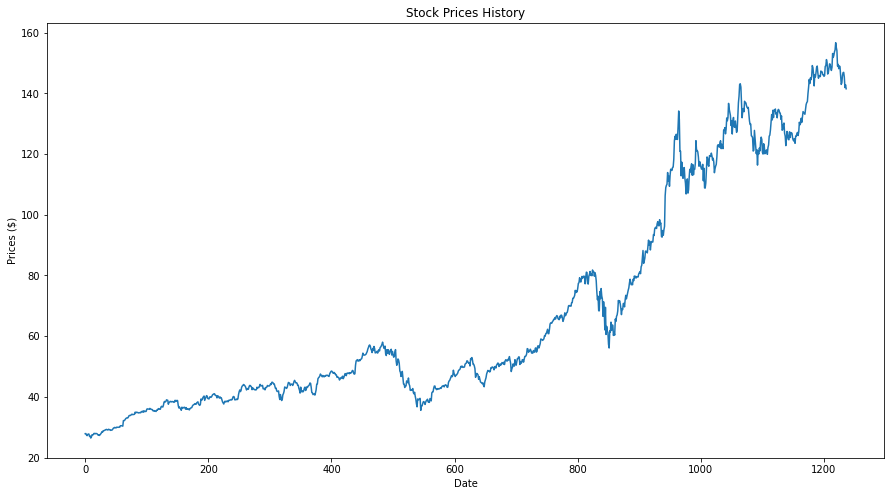

In [ ]:
# PLOTTING THE DATASET
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stockprices['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
# Train-Test split for time-series 
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))

print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['Date', 'Close']]
test = stockprices[train_size:][['Date', 'Close']]

# trainX = stockprices[:train_size][['Close']]
# testX = stockprices[train_size:][['Close']]

train_size: 989
test_size: 247


In [ ]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100
    return mape

In [ ]:
#SIMPLE MOVING AVERAGES
stockprices['100days'] = stockprices['Close'].rolling(100).mean()

# RMSE and MAPE of Simple Moving Averages
rmse_SMA100 = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:]['100days']))
mape_SMA100 = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:]['100days']))
print(rmse_SMA100)
print(mape_SMA100)


10.178922386102297
6.418805451354498


Text(0, 0.5, 'Prices ($)')

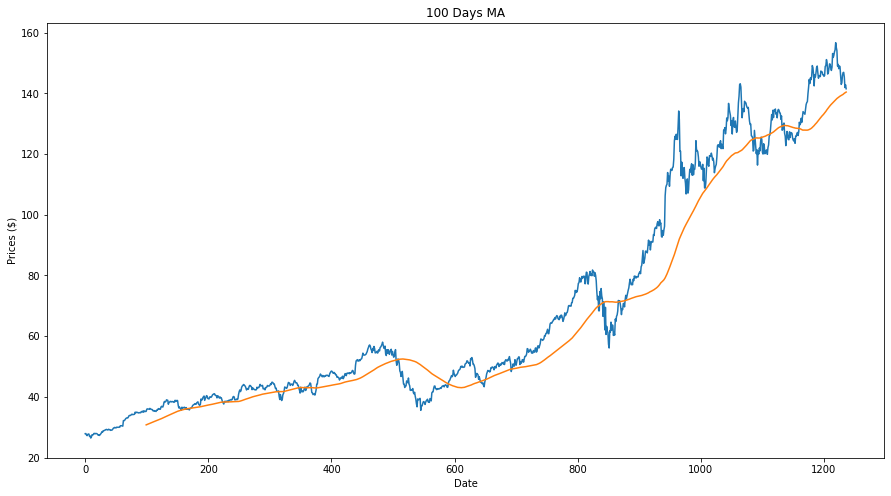

In [ ]:
#PLOTTING SIMPLE MOVING AVERAGES
plt.figure(figsize=(15, 8))
plt.title('100 Days MA')
plt.plot(stockprices['Close'])
plt.plot(stockprices['100days'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
#CALCULATING EXPONENTIAL MOVING AVERAGES 
stockprices['100Days'] = stockprices['Close'].ewm(span=100, adjust=False).mean()

# RMSE and MAPE of Exponential Moving Averages
rmse_EMA100 = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:]['100Days']))
mape_EMA100 = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:]['100Days']))
print(rmse_EMA100)
print(mape_EMA100)

10.066498262993335
6.393949044641876


Text(0, 0.5, 'Prices ($)')

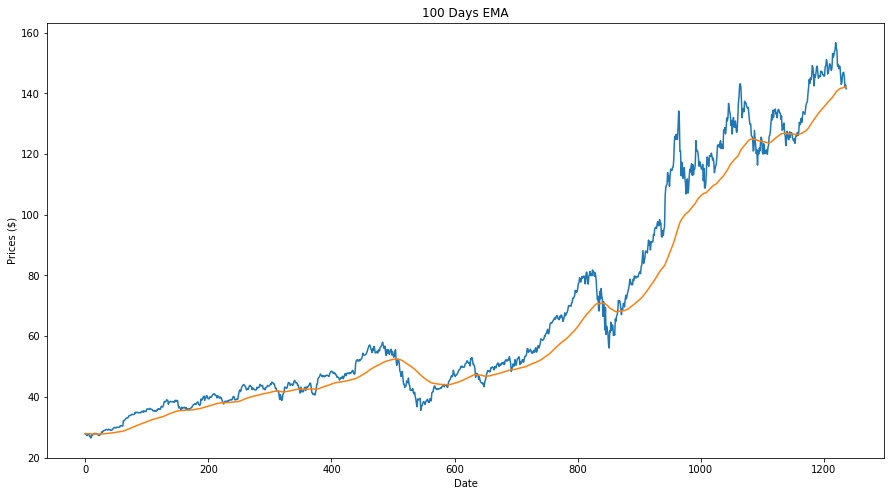

In [ ]:
#PLOTTING EXPONENTIAL MOVING AVERAGES
plt.figure(figsize=(15, 8))
plt.title('100 Days EMA')
plt.plot(stockprices['Close'])
plt.plot(stockprices['100Days'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**LSTM**

In [ ]:
# scale our dataset
scaler =  MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stockprices[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]


In [ ]:
x_train = []
y_train = []

for i in range(60, scaled_data_train.shape[0]):
    x_train.append(scaled_data_train[i-60:i])
    y_train.append(scaled_data_train[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=60, test=test):
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
#ML
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
929/929 [==============================] - 20s 19ms/step - loss: 0.0017
Epoch 2/3
929/929 [==============================] - 18s 19ms/step - loss: 7.9089e-04
Epoch 3/3
929/929 [==============================] - 18s 19ms/step - loss: 4.7210e-04


In [ ]:
# predict stock prices using past window_size stock price

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

test['Predictions_lstm'] = predicted_price

8/8 [==============================] - 1s 17ms/step


In [ ]:
# RMSE and MAPE of LSTM MODEL
rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
print(rmse_lstm)
print(mape_lstm)

2.707583768333171
1.6015668543708221


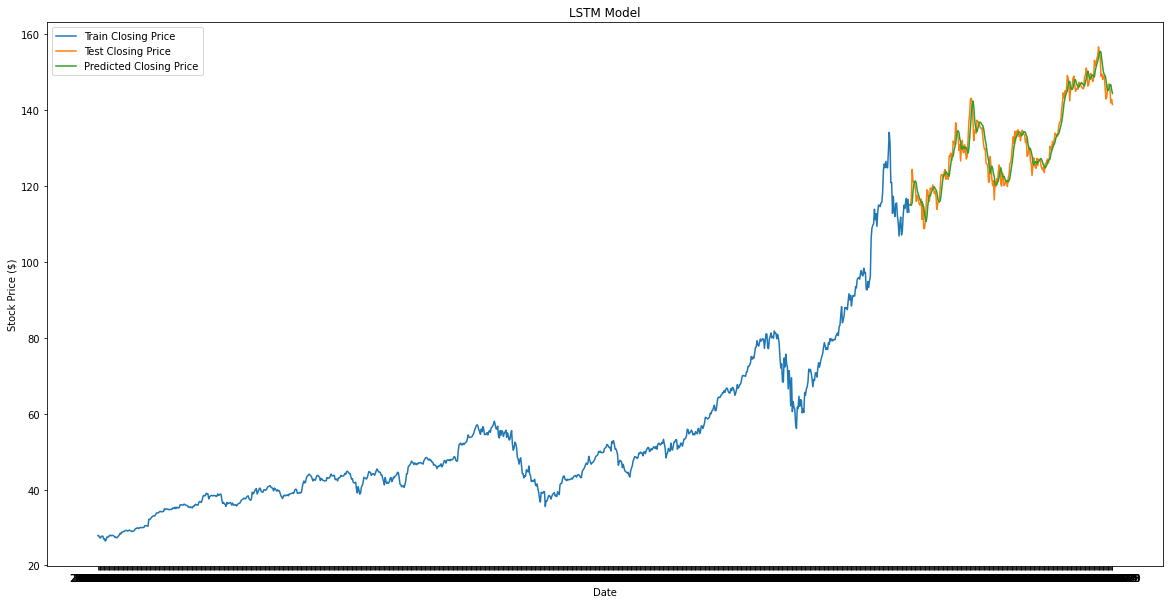

In [ ]:
# Plot predicted price vs actual closing price 
def plot_stock_trend_lstm(train, test, logNeptune=True):
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
plot_stock_trend_lstm(train, test)